# Regression task: the time interval between two consecutive visits for the same patient ~ ICD diagnosis code

## Prepare the dataset

In [1]:
""" 
Patient ID -> admission ID
"""

' \nPatient ID -> admission ID\n'

In [2]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from datetime import datetime
from mimic_common import *
import os
import pandas as pd
from sklearn.decomposition import PCA



In [3]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/mimic")
print(f"Will save outputs to {output_dir}")
data_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/mimic_exp/mimiciii")
print(f"Will read data from {data_dir}")

Will save outputs to /home/wanxinli/deep_patient/outputs/mimic
Will read data from /home/wanxinli/deep_patient/mimic_exp/mimiciii


In [4]:
admission_file = os.path.join(data_dir, "ADMISSIONS.csv")
diagnosis_file = os.path.join(data_dir, "DIAGNOSES_ICD.csv")
patient_file = os.path.join(data_dir, "PATIENTS.csv")

In [5]:
pid_adms, pid_gender, adm_date, admid_codes, pid_visits = build_maps(admission_file, diagnosis_file, patient_file)


In [6]:
# print(pid_visits)

In [7]:
# construct codes (ICD codes for the first visits), and durations (time interval until the next visit)

codes = []
durations = []
genders = []
for pid, visits in pid_visits.items():
    for i, cur_visit in enumerate(visits):
        if i == len(visits)-1: # stop on the last element
            break 
        next_visit = visits[i+1]
        # print(next_visit)
        cur_codes = cur_visit[1]
        # print(codes)
        duration = (next_visit[0]-cur_visit[0]).total_seconds()
        codes.append(cur_codes)
        durations.append(duration)
        genders.append(pid_gender[pid])


cons_visits_df = pd.DataFrame(columns=['gender', 'duration', 'ICD codes'])
cons_visits_df['gender'] = genders
cons_visits_df['duration'] = durations
cons_visits_df['ICD codes'] = codes
cons_visits_df.to_csv(os.path.join(output_dir, "CONS_VISITS.csv"), index=False, header=True)

cons_visits_df

,gender,duration,ICD codes
0,M,130162740.0,"[41401, 4111, 4241, V4582, 2724, 4019, 60000, ..."
1,M,145197420.0,"[41071, 4280, 4254, 42731, 9971, 4260, 41401, ..."
2,M,1082040.0,"[41401, 4111, 496, 4019, 3051, 53081, 60000, V..."
3,M,94491660.0,"[99831, 99811, 41511, 4538, 99672, 496, 41401,..."
4,M,20640960.0,"[5715, 5722, 2867, 45620, 3453, 48241, 51881, ..."
...,...,...,...
12451,M,9735840.0,"[42731, 56211, V1051]"
12452,M,8103720.0,"[99859, 0389, 99592, 78552, 5849, 5990, 42830,..."
12453,F,2644440.0,"[4373, 4019, 2449, 59651, 49390, V1052]"
12454,F,1994400.0,"[5363, 5641]"


In [8]:
""" 
Outputs consecutive visit stats
"""
female_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'F')].shape[0]
male_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'M')].shape[0]
print("female count is:", female_count)
print("male count is:", male_count)

female count is: 5627
male count is: 6829


In [9]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var)
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var)

    return target_reps, source_reps

In [11]:
n_components = 50
model_func = linear_model.LinearRegression
entire_proc_cts(n_components, cons_visits_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=False)

/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(34519726.7440978,
 49348158.01071208,
 42982453.05733716,
 53613048.60264041,
 39791017.56730453,
 51558314.85717534)

In [13]:
""" 
Run multiple iterations
"""
score_path = os.path.join(output_dir, "exp5_score.csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, cons_visits_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.LinearRegression, iteration=100)

iteration: 0
iteration: 1
iteration: 2


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 3


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 4


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 12
iteration: 13


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 19


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 25
iteration: 26
iteration: 27


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 28
iteration: 29


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 43
iteration: 44


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 45


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 46


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 47
iteration: 48


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 49
iteration: 50


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 51


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 52
iteration: 53
iteration: 54


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 55
iteration: 56


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 57


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 58


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 59
iteration: 60


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 61
iteration: 62
iteration: 63


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 64
iteration: 65


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 66
iteration: 67
iteration: 68


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 69


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 70
iteration: 71


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 72
iteration: 73


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 74


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 75
iteration: 76


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 77
iteration: 78


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 79


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 80
iteration: 81
iteration: 82
iteration: 83
iteration: 84


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 85


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 86
iteration: 87
iteration: 88


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 89


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 90
iteration: 91


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 97


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 98


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 99


array([[36883669.65567892, 51961707.55373504, 50678070.7097654 ,
        67482163.8030879 , 47914185.19688696, 63379266.16161672],
       [29842702.13841722, 43643780.50105147, 48113264.78363384,
        69575549.76753898, 44384291.6063962 , 65879727.57898752],
       [27078770.21508212, 42017103.04216892, 42476908.89823696,
        55686980.15142758, 38426802.82438891, 51832781.74741042],
       [35658392.25397453, 54019133.55289261, 52559633.31638248,
        68482394.23278981, 47363298.98232397, 68422637.1808754 ],
       [32760703.35911833, 47216832.42600156, 47729951.84243596,
        65808083.33843751, 44787158.39295986, 63625035.07647277],
       [26701817.25798034, 39305615.96431127, 41536045.86366253,
        54126076.44593313, 34168662.54910908, 43689061.40254717],
       [31373899.83209838, 43937327.9107194 , 38558299.17627967,
        50946804.54612491, 33926699.92264866, 46718000.45518016],
       [22931243.30904353, 35526954.71189315, 40740762.20173529,
        53724685.5

<Figure size 640x480 with 0 Axes>

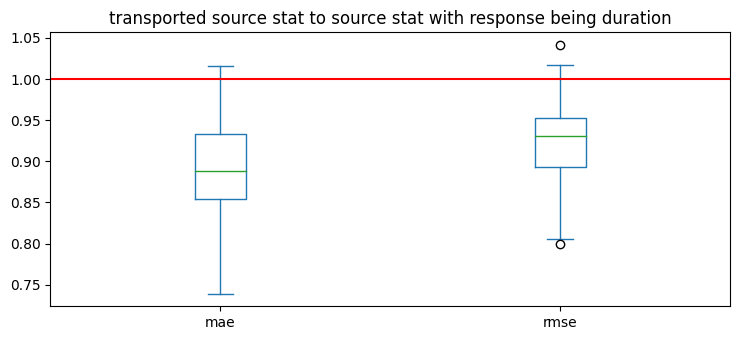

(0.8887448554654767, 0.930474376630074)

In [14]:
box_plot_cts_short(score_path)